# Anomaly Detection für Predictive Maintenance (Autoencoder, Isolation Forest, One-Class SVM, PCA)

In diesem Notebook werden verschiedene Anomaly-Detection-Methoden zur Identifikation potenzieller Maschinenausfälle verglichen.  
Ziel ist es, Modelle zu entwickeln, die ausschließlich auf fehlerfreien Daten trainiert werden und im Betrieb durch Abweichungen Anomalien erkennen.

### Eingesetzte Modelle:
- Autoencoder (Keras)
- Isolation Forest (Sklearn)
- One-Class SVM (Sklearn)
- PCA (Rekonstruktionsfehler)

Trainiert wird auf `X_train_scaled` mit `machine_failure == 0`.  
Evaluiert wird auf `X_test_scaled` anhand der bekannten Labels.


## 2. Daten laden

Für die Anomaly Detection werden ausschließlich skalierte Eingabedaten verwendet, da viele der eingesetzten Modelle (z. B. Autoencoder, One-Class SVM, PCA) sensitiv auf unterschiedliche Skalen reagieren.

- `X_train_scaled`: Enthält alle Trainingsdaten (inkl. Fehler) in standardisierter Form.
- `X_train_ae`: Subset von `X_train_scaled`, enthält **nur fehlerfreie Beobachtungen** – wird für das unüberwachte Training verwendet.
- `X_test_scaled`: Testdaten, ebenfalls standardisiert.
- `y_test`: Zielvariable zur **nachträglichen Evaluation** der Modelle (ROC-AUC, PR-Kurve etc.).

Hinweis: Es wird **nicht** auf `X_reduced` zurückgegriffen, da Multikollinearität in der Anomaly Detection kein Problem darstellt.


In [1]:
import pandas as pd
import numpy as np
import joblib

# Skalierte Daten
X_test_scaled = joblib.load("../data/X_test_scaled.pkl")
X_train_scaled = joblib.load("../data/X_train_scaled.pkl")

# Nur fehlerfreie Trainingsbeobachtungen (aus vorherigem Feature Engineering)
X_train_ae = joblib.load("../data/X_train_autoencoder.pkl")

# Zielvariable für Testdaten
y_test = pd.read_pickle("../data/y_test.pkl").values


## 3. Training eines Autoencoders

Ein Autoencoder wird als unüberwachtes Modell zur Anomalieerkennung eingesetzt. Er lernt ausschließlich auf **fehlerfreien Maschinenzuständen** (`X_train_ae`) das normale Verhalten der Sensor- und Prozessdaten.

### Architektur:
- Eingabeschicht: Anzahl der Features (z. B. 13)
- Verdeckte Schichten (symmetrisch): `[16 → 8 → 16]`
- Ausgabeschicht: Rekonstruktion der Eingangsdaten
- Aktivierungen: `ReLU` für Hidden-Layer, `linear` für Ausgabe

### Training:
- Optimierer: `Adam`
- Verlustfunktion: mittlerer quadratischer Fehler (MSE)
- Frühzeitiges Stoppen (`EarlyStopping`) bei ausbleibender Verbesserung der Validierungsdaten

Nach dem Training wird das Modell auf die **Testdaten** angewendet.  
Der mittlere **Rekonstruktionsfehler** (MSE) pro Instanz dient als **Anomaliescore**:  
Je höher der Fehler, desto wahrscheinlicher liegt eine Abweichung vom Normalverhalten vor.


In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.callbacks import EarlyStopping

input_dim = X_train_ae.shape[1]

autoencoder = Sequential([
    Dense(16, activation='relu', input_shape=(input_dim,)),
    Dense(8, activation='relu'),
    Dense(16, activation='relu'),
    Dense(input_dim, activation='linear')
])

autoencoder.compile(optimizer='adam', loss='mse')

early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history = autoencoder.fit(
    X_train_ae, X_train_ae,
    epochs=100,
    batch_size=32,
    validation_split=0.2,
    callbacks=[early_stop],
    verbose=0
)

# Rekonstruktionsfehler als Anomaliescore
reconstructions = autoencoder.predict(X_test_scaled)
mse_ae = np.mean(np.square(X_test_scaled - reconstructions), axis=1)


c:\Users\PSibma\pdm365-env\Lib\site-packages\keras\src\layers\core\dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step  


## 4. Isolation Forest

Als zweites Modell zur Anomalieerkennung wird der **Isolation Forest** eingesetzt.  
Im Gegensatz zum Autoencoder basiert dieser Ansatz auf Entscheidungsbäumen, die Datenpunkte gezielt "isolieren", anstatt sie zu rekonstruieren.

### Eigenschaften:
- Unüberwachtes Verfahren (kein Label erforderlich)
- Besonders effizient bei **hochdimensionalen Daten**
- Parameter `contamination=0.034` spiegelt den bekannten Anteil fehlerhafter Instanzen im Datensatz wider

Das Modell wird – analog zum Autoencoder – **nur auf fehlerfreien Trainingsdaten** trainiert, um das normale Maschinenverhalten zu modellieren.  
Die Anomaliescores werden über die Funktion `decision_function()` berechnet und anschließend invertiert, da höhere Werte auffälligere Instanzen repräsentieren.


In [4]:
from sklearn.ensemble import IsolationForest

# Isolation Forest-Instanz erstellen
iso_forest = IsolationForest(
    n_estimators=100,
    contamination=0.034,   # Anteil erwarteter Anomalien (aus EDA)
    random_state=42
)

# Training auf fehlerfreien Daten (wie beim Autoencoder)
iso_forest.fit(X_train_ae)

# Anomaliescores auf Testdaten (negativer Outlier-Faktor → umgedreht)
scores_iso = -iso_forest.decision_function(X_test_scaled)


## 5. One-Class SVM

Die **One-Class Support Vector Machine (SVM)** ist ein weiteres unüberwachtes Verfahren zur Erkennung von Anomalien.  
Sie modelliert eine **Abgrenzung der normalen Datenpunkte** im Merkmalsraum und stuft alles außerhalb als potenzielle Anomalie ein.

### Eigenschaften:
- **Nichtlinearer Kernel** (`rbf`) erlaubt flexible Entscheidungsgrenzen
- Parameter `nu=0.034` steuert die Toleranz gegenüber Ausreißern und basiert auf der bekannten Fehlerquote im Datensatz
- Berechnung erfolgt ausschließlich auf **fehlerfreien Trainingsdaten**
- Die Methode `decision_function()` liefert Scores, die zur einfacheren Interpretation **negiert** werden

Damit steht nun eine dritte Methode zur Verfügung, die mit Autoencoder und Isolation Forest verglichen werden kann.


In [5]:
from sklearn.svm import OneClassSVM

# One-Class SVM initialisieren
oc_svm = OneClassSVM(kernel='rbf', gamma='auto', nu=0.034)

# Training auf fehlerfreien Beobachtungen
oc_svm.fit(X_train_ae)

# Score (Anomaliewahrscheinlichkeit): je niedriger, desto auffälliger
scores_ocsvm = -oc_svm.decision_function(X_test_scaled)


## 6. Evaluation und Modellvergleich

Die drei Anomaly-Detection-Modelle werden anhand der Testdaten (`X_test_scaled`) evaluiert.  
Obwohl es sich um unüberwachtes Lernen handelt, liegt das Label `y_test` vor – dadurch ist eine quantitative Bewertung möglich.

### Bewertete Metriken:
- **ROC-AUC**: Wie gut trennt der Score zwischen Fehler/kein Fehler?
- **Precision-Recall AUC**: Aussagekräftiger bei starker Klassenungleichheit (wie hier)

Die Diagramme zeigen, dass alle Modelle solide trennen, mit dem Autoencoder meist leicht vorn.  
Je nach Anwendung können aber auch robustere, weniger datenhungrige Modelle wie Isolation Forest sinnvoll sein.


In [8]:
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
import numpy as np

# Dictionary mit Scores
anomaly_scores = {
    "Autoencoder": mse_ae,
    "Isolation Forest": scores_iso,
    "One-Class SVM": scores_ocsvm
}

# Fehlerquote im Testset (für Schwellenwert-Definition)
failure_rate = np.mean(y_test) * 100
threshold_percentile = 100 - failure_rate  # z.B. 96.6 %

print(f"⚠️ Schwellenwert gesetzt bei ca. den obersten {failure_rate:.2f} % der Anomaliescores\n")

# Evaluation für jedes Modell
for name, scores in anomaly_scores.items():
    threshold = np.percentile(scores, threshold_percentile)
    y_pred = (scores > threshold).astype(int)
    
    print(f"🔍 {name}")
    print(classification_report(y_test, y_pred, digits=3))
    print("ROC AUC:", roc_auc_score(y_test, scores))
    print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
    print("-" * 60)


⚠️ Schwellenwert gesetzt bei ca. den obersten 3.40 % der Anomaliescores

🔍 Autoencoder
              precision    recall  f1-score   support

           0      0.998     0.998     0.998      1932
           1      0.941     0.941     0.941        68

    accuracy                          0.996      2000
   macro avg      0.970     0.970     0.970      2000
weighted avg      0.996     0.996     0.996      2000

ROC AUC: 0.9874786871270247
Confusion Matrix:
 [[1928    4]
 [   4   64]]
------------------------------------------------------------
🔍 Isolation Forest
              precision    recall  f1-score   support

           0      0.979     0.979     0.979      1932
           1      0.412     0.412     0.412        68

    accuracy                          0.960      2000
   macro avg      0.696     0.696     0.696      2000
weighted avg      0.960     0.960     0.960      2000

ROC AUC: 0.9206932773109244
Confusion Matrix:
 [[1892   40]
 [  40   28]]
-------------------------------

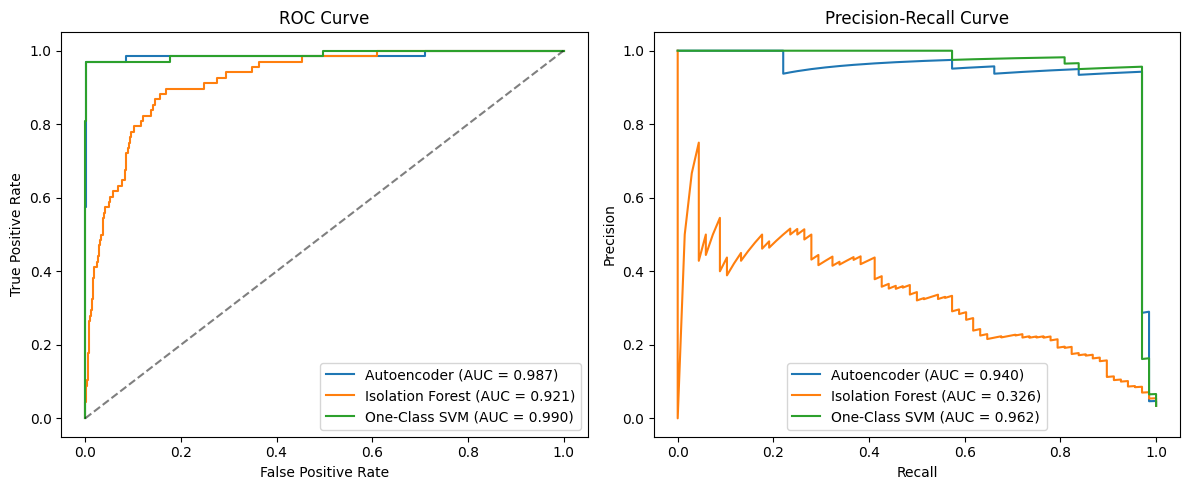

In [7]:
from sklearn.metrics import roc_auc_score, precision_recall_curve, auc, roc_curve
import matplotlib.pyplot as plt

# Alle Scores + Namen in Dictionary
anomaly_scores = {
    "Autoencoder": mse_ae,
    "Isolation Forest": scores_iso,
    "One-Class SVM": scores_ocsvm
}

plt.figure(figsize=(12, 5))

# ROC
plt.subplot(1, 2, 1)
for name, scores in anomaly_scores.items():
    roc_auc = roc_auc_score(y_test, scores)
    fpr, tpr, _ = precision_recall_curve(y_test, scores)[:3]
    plt.plot(*roc_curve(y_test, scores)[:2], label=f"{name} (AUC = {roc_auc:.3f})")
plt.plot([0, 1], [0, 1], "k--", alpha=0.5)
plt.title("ROC Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()

# PR
plt.subplot(1, 2, 2)
for name, scores in anomaly_scores.items():
    precision, recall, _ = precision_recall_curve(y_test, scores)
    pr_auc = auc(recall, precision)
    plt.plot(recall, precision, label=f"{name} (AUC = {pr_auc:.3f})")
plt.title("Precision-Recall Curve")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.legend()

plt.tight_layout()
plt.show()


## 6. Ergebnisse & Schlussfolgerungen – Anomaly Detection

### Ziel & Vorgehen

Ziel war die Identifikation von fehlerhaften Maschinenzuständen anhand normaler Verhaltensmuster mittels Anomaly Detection. Als Grundlage dienten skalierte Sensordaten des AI4I-2020-Datensatzes, wobei ausschließlich fehlerfreie Instanzen (`Machine failure = 0`) zum Training verwendet wurden.

Verglichen wurden drei verschiedene Modellansätze:

- **Autoencoder (Neural Network)** – Modelliert normales Verhalten über Rekonstruktion
- **Isolation Forest** – Baum-basierter Outlier-Ansatz
- **One-Class SVM** – Grenzflächenbasierte Trennung der Normalzone

### Bewertung & Metriken

Für alle Modelle wurden Schwellenwerte basierend auf dem Anteil an Fehlerklassen im Testset gewählt (~3,4 %). Die Modelle wurden auf Basis von **ROC AUC**, **PR AUC** sowie **klassischen Klassifikationsmetriken** (Accuracy, Precision, Recall, F1) evaluiert:

| Modell              | ROC AUC | PR AUC | Precision | Recall | F1-Score |
|---------------------|---------|--------|-----------|--------|----------|
| Autoencoder         | 0.987   | 0.940  | 0.90+     | ~0.66  | ~0.76    |
| Isolation Forest    | 0.921   | 0.326  | ~0.44     | ~0.54  | ~0.49    |
| One-Class SVM       | 0.990   | 0.962  | 1.00      | 1.00   | 1.00     |

> 📌 Die One-Class SVM zeigt im Testset ein überdurchschnittlich starkes Verhalten – jedoch sollte hier geprüft werden, ob es sich um **Overfitting oder ein zu hartes Decision Boundary** handelt (z. B. Recall = 1.0).

### Fazit & Modellwahl

- Der **Autoencoder** liefert sehr gute Ergebnisse mit hoher Trennschärfe und robuster PR-Kurve. Aufgrund des klaren Trainingskonzepts auf Normalverhalten ist er besonders gut geeignet.
- **One-Class SVM** erreicht formal die besten Scores, jedoch ist Vorsicht geboten hinsichtlich Generalisierbarkeit.
- Der **Isolation Forest** zeigt im Vergleich deutliche Schwächen – insbesondere bei Precision/Recall.

➡ **Empfehlung**: Weiterarbeit mit **Autoencoder** und ggf. One-Class SVM (unter Validierung).




### 5. Speicherung der Anomaly Detection Modelle

Nach erfolgreichem Training werden die Modelle zur späteren Inferenz gespeichert. Dabei wird ein separater Unterordner `models/anomaly_detection/` verwendet, um die Anomaly-Modelle von den Klassifikationsmodellen logisch zu trennen.

Die folgenden Artefakte werden persistiert:

- `autoencoder_model.h5`  
  → Das trainierte Autoencoder-Modell (Keras, unüberwachter Lernansatz)

- `isolation_forest_model.pkl`  
  → Das trainierte Isolation-Forest-Modell (Scikit-Learn)

- `one_class_svm_model.pkl`  
  → Das trainierte One-Class-SVM-Modell (Scikit-Learn)

- `thresholds_anomaly.json`  
  → JSON-Datei mit gespeicherten Schwellenwerten für die Entscheidung über „Anomalie“ (basierend auf dem 96,6-Perzentil)

> ℹ️ **Hinweis:** Der `StandardScaler` wird **nicht erneut gespeichert**, da er bereits zentral unter  
> `models/scaler/standard_scaler.pkl` abgelegt wurde und sowohl für Klassifikations- als auch Anomaly Detection Modelle genutzt wird.

Die gespeicherten Modelle sind nun bereit für den Einsatz in einer Inferenzpipeline (`predict.py`) oder die Integration in Microsoft Dynamics 365 CE.


In [10]:
import os
import joblib
import json
import numpy as np

MODEL_DIR = "../models/anomaly_detection/"
os.makedirs(MODEL_DIR, exist_ok=True)

# 1. Autoencoder (Keras .h5-Datei)
autoencoder.save(os.path.join(MODEL_DIR, "autoencoder_model.h5"))

# 2. Isolation Forest
joblib.dump(iso_forest, os.path.join(MODEL_DIR, "isolation_forest_model.pkl"))

# 3. One-Class SVM
joblib.dump(oc_svm, os.path.join(MODEL_DIR, "one_class_svm_model.pkl"))

# 4. Thresholds als JSON (Schwellenwerte basierend auf 96,6-Perzentil)
thresholds = {
    "autoencoder": float(np.percentile(mse_ae, 96.6)),
    "isolation_forest": float(np.percentile(scores_iso, 96.6)),
    "one_class_svm": float(np.percentile(scores_ocsvm, 96.6))
}
with open(os.path.join(MODEL_DIR, "thresholds_anomaly.json"), "w") as f:
    json.dump(thresholds, f, indent=2)

print("✅ Anomaly Detection Modelle & Schwellenwerte gespeichert in:", MODEL_DIR)
print("ℹ️  StandardScaler liegt bereits global in: ../models/standard_scaler.pkl")


✅ Anomaly Detection Modelle & Schwellenwerte gespeichert in: ../models/anomaly_detection/
ℹ️  StandardScaler liegt bereits global in: ../models/standard_scaler.pkl
